# CYBER Master

This project is to process the data of recorded voices and baseline measurements for the attachment style interaction with depression and anxiety, in a sense this will work a the ETL or pre-processing of the data.

This notebook has a single purpose expressed in the following steps:
- Gather the answers from the survey DB
- Process the answers by uniques and present a report of the demographics, attachment styles and HADS answers
- From each answer, get the recordings from blob storage.
- For each recording transcribe them and associate them to the answer
- Store the resulting data in the DB for further analysis

In [2]:
# -*- coding: utf-8 -*-

# Import the necessary libraries
import os
import json
from datetime import datetime
from dotenv import load_dotenv, find_dotenv
import subprocess
import requests
from typing import List, Tuple, Optional
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv(find_dotenv())

CONSENT_SURVEY_ID = "8"
STUDY_SURVEY_ID = "7"
OLLAMA_VERSION = "v0.12"

QUESTIONS = {
    "en": {
        "1": "What’s happening in the picture?",
        "2": "What led up to that scene?",
        "3": "What the characters are thinking or feeling?",
        "4": "What might happen next?",
    },
    "es": {
        "1": "¿Qué está pasando en la imagen?",
        "2": "¿Qué eventos llevaron a esta escena?",
        "3": "¿Qué están sintiendo o pensando los personajes?",
        "4": "¿Qué ocurrirá a continuación?",
    },
}

IMAGE_KEYS = [
    "Image 1 - 1",
    "Image 1 - 2",
    "Image 1 - 3",
    "Image 1 - 4",
    "Image 2 - 1",
    "Image 2 - 2",
    "Image 2 - 3",
    "Image 2 - 4",
    "Image 3 - 1",
    "Image 3 - 2",
    "Image 3 - 3",
    "Image 3 - 4",
    "Image 4 - 1",
    "Image 4 - 2",
    "Image 4 - 3",
    "Image 4 - 4",
    "Image 5 -1",
    "Image 5 - 2",
    "Image 5 - 3",
    "Image 5 - 4",
    "Image 6 - 1",
    "Image 6 - 2",
    "Image 6 - 3",
    "Image 6 - 4",
    "Image 7 - 1",
    "Image 7 - 2",
    "Image 7 - 3",
    "Image 7 - 4",
    "Image 8 - 1",
    "Image 8 - 2",
    "Image 8 - 3",
    "Image 8 - 4",
]


def transcribe_audio(file_path, language="en"):
    # Use the local vosk via CLI to get the transcription
    result_file = file_path.replace(".wav", ".txt")
    subprocess.run(
        [
            "vosk-transcriber",
            "-i",
            file_path,
            "-l",
            language,
            "-o",
            result_file,
            "--log-level",
            "INFO",
        ]
    )
    # Read the transcription
    with open(result_file, "r") as transcription_file:
        transcription = transcription_file.read()
        return transcription


def request_llm_analysis(prompts: List[str], language="en"):
    url = "http://localhost:11434/api/generate"
    prompt = (
        "No explanations or additional information should be included in the answer only the results, Consider only the following information."
        + " answer only in one line, do not include any additional information or context, answer in the format:"
        + " 'Attachment style: [secure|insecure], Anxiety: [], Depression: []'"
        + " treat each prompt as if it comes from a person with a different attachment style, anxiety, and depression levels."
    )
    prompt += " ".join(prompts)
    data = {
        "prompt": prompt,
        "model": OLLAMA_VERSION,
    }
    response = requests.post(url, json=data)
    result = ""
    for line in response.text.split("\n"):
        if '"done": true' in line or not line:
            return result
        else:
            try:
                result += json.loads(line)["response"]
            except Exception as e:
                print(e)
                print(line)
                continue

    return result


def score_HADS(answers: dict) -> tuple:
    anxiety_items = {
        "HADS 1": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 5": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 6": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 8": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 9": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 12": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 13": {"0": 3, "1": 2, "2": 1, "3": 0},
    }
    depression_items = {
        "HADS 2": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 3": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 4": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 7": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 10": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 11": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 14": {"0": 0, "1": 1, "2": 2, "3": 3},
    }

    anxiety_score = 0
    depression_score = 0

    for item, answer in answers.items():
        if item in anxiety_items:
            anxiety_score += anxiety_items[item][answer]
        elif item in depression_items:
            depression_score += depression_items[item][answer]

    return anxiety_score, depression_score


def score_RQ(answers: dict) -> dict:
    anxiety_score = 0
    avoidance_score = 0

    styles = {
        "A": "Secure",
        "B": "Fearful",
        "C": "Preoccupied",
        "D": "Dismissing",
    }

    results = {}
    for item, answer in answers.items():
        if item == "RQ1":
            results["style"] = styles[answer]
        elif item == "RQ2":
            anxiety_score += int(answer)
            avoidance_score += int(answer)
        elif item == "RQ3":
            anxiety_score -= int(answer)
            avoidance_score -= int(answer)
        elif item == "RQ4":
            anxiety_score -= int(answer)
            avoidance_score += int(answer)
        elif item == "RQ5":
            anxiety_score += int(answer)
            avoidance_score -= int(answer)

    results["anxiety"] = anxiety_score
    results["avoidance"] = avoidance_score
    return results


def get_only_numbers(text: str) -> str:
    return "".join(filter(str.isdigit, text))


def get_styles_percentage(
    styles: list, percentages: bool = False
) -> Tuple[str, Optional[dict]]:
    result = {}
    total = len(styles)
    for style in styles:
        if style not in result:
            result[style] = styles.count(style)
    style = max(result, key=result.get)
    if percentages:
        return style, {key: value / total for key, value in result.items()}
    return style


def get_scores_average(scores: list[int]) -> float:
    if len(scores) == 0:
        return 0
    return sum(scores) / len(scores)


now_date = datetime.now().strftime("%Y-%m-%d--%H-%M")

## Connect to the DB

In [3]:
import mysql.connector

connection = mysql.connector.connect(
    user=os.getenv("DB_USERNAME"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    database=os.getenv("DB_NAME"),
    port=os.getenv("DB_PORT"),
)
cursor = connection.cursor()

# query the answers table
query = (
    f"SELECT * FROM surveys_answer where surveys_answer.survey_id = {STUDY_SURVEY_ID}"
)
cursor.execute(query)
answers = cursor.fetchall()

In [5]:
# Parse the answers
json_answers = []

for answer in answers:
    dict_answer = json.loads(json.loads(answer[1]))
    if dict_answer.get("response-uuid") not in [
        answer.get("response-uuid") for answer in json_answers
    ]:
        json_answers.append({"id": answer[0], **json.loads(json.loads(answer[1]))})
    else:
        for json_answer in json_answers:
            if json_answer.get("response-uuid") == dict_answer.get("response-uuid"):
                json_answer.update(json.loads(json.loads(answer[1])))
                break

full_answers = [answer for answer in json_answers if len(answer.keys()) >= 62]
# get answers by language in a dictionary
answers_by_language = {}
answers_by_language = {
    "en": len([answer for answer in full_answers if answer["language"] == "en"]),
    "es": len([answer for answer in full_answers if answer["language"] == "es"]),
    "pt": len([answer for answer in full_answers if answer["language"] == "pt"]),
}
print(answers_by_language)

{'en': 38, 'es': 12, 'pt': 0}


In [6]:
# Get the excluded answers
excluded_answers = []
for answer in json_answers:
    if "Demographic - speech diagnosis" not in answer.keys() or "Demographic - psychiatric disorder" not in answer.keys() or "Demographic - Substances" not in answer.keys():
        continue
    if answer["Demographic - speech diagnosis"] == "yes" or answer["Demographic - psychiatric disorder"] == "yes" or answer["Demographic - Substances"] == "yes":
        excluded_answers.append(answer)

print(len(excluded_answers))

58


In [7]:
# Get the recording info from the recording table
recordings_query = f"SELECT * FROM surveys_recording"  # where surveys_recording.answer_id in ({','.join([str(answer.get('id')) for answer in full_answers])})"
cursor.execute(recordings_query)
recordings = cursor.fetchall()

In [8]:
for answer in full_answers:
    for recording in recordings:
        for key, value in answer.items():
            if not isinstance(value, str) or len(value) < 4:
                continue
            if value.replace("-", "") != recording[-1]:
                continue
            answer[key] = f"{recording[1].replace('recordings/', '')}.wav"

## Getting the recordings per answer

In [9]:
from azure.storage.blob import BlobServiceClient

CONTAINER_NAME = "recordings"

blob_service = BlobServiceClient.from_connection_string(
    os.getenv("AZURE_CONNECTION_STRING")
)
local_path = "./recordings"
# create the folder if not alrady
if not os.path.exists(local_path):
    os.mkdir(local_path)

# Sanity check, listing the blobs in the container
container_client = blob_service.get_container_client(CONTAINER_NAME)
blob_list = []
for blob in container_client.list_blobs():
    if "blob" in blob.name:
        blob_list.append(blob.name)

In [10]:
# Download the blobs into the recordings folder if not already downloaded
for blob in blob_list:
    result_file_name = blob.split("/")[-1]
    result_file_name = f"{result_file_name}.wav"
    if result_file_name not in os.listdir(local_path):
        with open(file=f"{local_path}/{result_file_name}", mode="wb") as audio_file:
            download_stream = container_client.download_blob(blob)
            audio_file.write(download_stream.readall())

# list all the files in the folder
files = os.listdir(local_path)
print(len(files))

3280


## Vosk

We are using [vosk](https://alphacephei.com/vosk/) to transcribe the audio into text, then assign it to the answer for further processing

In [ ]:
for answer in full_answers:
    for key, value in answer.items():
        if not isinstance(value, str) or not value.endswith(".wav"):
            continue
        if value not in files:
            print(f"File {value} not found")
            continue
        if value.replace(".wav", ".txt") in os.listdir(local_path):
            print(f"File {value} already transcribed")
            answer[key] = open(
                f"{local_path}/{value.replace('.wav', '.txt')}", "r"
            ).read()
            continue
        answer[key] = transcribe_audio(
            f"{local_path}/{value}", language=answer["language"]
        )

In [9]:
for answer in full_answers:
    for key, value in answer.items():
        if not isinstance(value, str) or not value.endswith(".wav"):
            continue
        if value not in files:
            print(f"File {value} not found")
            continue
        if value.replace(".wav", ".txt") in os.listdir(local_path):
            print(f"File {value} already transcribed")
            answer[key] = open(
                f"{local_path}/{value.replace('.wav', '.txt')}", "r"
            ).read()
            continue
        answer[key] = transcribe_audio(
            f"{local_path}/{value}", language=answer["language"]
        )

## Scoring the validated scales

We are using the HADS and RQ scales to determine the anxiety and depression, and the attachment style status accordingly.

### HADS - Hospital Anxiety and Depression Scale
A self report tool developed in 1983 by [Zigmond and Snaith](https://pubmed.ncbi.nlm.nih.gov/6880820/). It allows a dimensional scoring of the status of the patient and allows the better understanding of the psychiatric and psychological needs of a hospital patient.

The scale is composed of 14 items in a 4-item likert scale pointed from 0 to 3 and dedicates 7 items to depression and anxiety respectively. The scoring occurs by aggregating the values of each item and group, therefore, distributed as follows:
- Scores 0 to 7: Normal
- Scores 8 to 10: Borderline abnormal (at risk(?))
- Scores 11 - 21:  Abnormal (Usually requires a proper diagnosis and treatment)


### RQ - The Relationship Questionnaire
A self report questionnaire developed in 1991 by [Bartholomew & Horowitz](https://pubmed.ncbi.nlm.nih.gov/1920064/) composed of two segments with the objective of measuring the adult attachment styles. the styles are defined on two axis: Avoidance and anxiety.
The avoidance axis refers to the internal model of others and the anxiety to the internal model of self and usually presented as a cartesian plane, in which an adult may have a combination of both axis.
The four general cartesian regions in the adult attachment are:
**Secure**: Low avoidance - Low anxiety: The person considers others and themselves as trustworthy.
**Preoccupied**: Low avoidance - High anxiety: The person considers others are more trustworthy and generate a dependency due to internal low self-worth.
**Dismissing**: High avoidance - Low anxiety: The person has low trust on others but is self-reliant (opossite to the one above).
**Fearful**: High avoidance - High anxiety: The person does not trust others and has low self worth.

In this scale a person will first select a paragraph that reflects directly one of the styles above, then rates the agreement with each style prototype in a 7-item likert scales. From the answers in the likert scales the values on both axis are extracted and calculated as follows:
- **Model of self**: (secure + dissmissing) - (preocupied + fearful)
- **Model of others**: (secure + preocupied) - (dissmissing + fearful)

In [10]:
# Score HADS and RQ from the full_answers
for answer in full_answers:
    answer["HADS score - Anxiety"], answer["HADS score - Depression"] = score_HADS(
        {f"HADS {i}": answer.get(f"HADS {i}") for i in range(1, 15)}
    )
    answer["RQ score"] = score_RQ({f"RQ{i}": answer.get(f"RQ{i}") for i in range(1, 6)})

## Invoquing OLlama model using the prompts

The audio tracks were transcribed and will be fed in a custom prompt to a local Llama2 model using the [OLlama framework](https://ollama.com/)([Git hub documentation](https://github.com/ollama/ollama)).

The model has been pretrained by setting the `seed`, to ensure more deterministic results, and with a preparation prompt with extra instructions. The model is asked to act as a psiquiatrist assistant and given some context about the attachment styles, following the best practices mentioned in the literature ([1](https://arxiv.org/abs/2309.09128), [2](https://www.jmir.org/2023/1/e50638/), [3](https://link.springer.com/chapter/10.1007/978-981-99-7962-2_30)) The prompts and settings used in setup are available in the file `Modelfile` in this repository.


Then for each participant we agreggate all answers to the images and ask the model to determine the attachment style and two percentages for anxiety and depression afterwards.

In [11]:
# prepare the prompt to be fed to the LLM
for answer in full_answers:
    answer["prompts"] = []
    for key in IMAGE_KEYS:
        if answer.get(key) is None:
            continue
        answer.get("prompts").append(
            f"{key[0:8]} - {QUESTIONS.get(answer.get('language')).get(key[-1])} {answer[key]}"
        )

In [ ]:
# request the LLM analysis

for answer in full_answers:
    answer["llm"] = []
    answer["llm_attachment_style"] = []
    answer["llm_anxiety"] = []
    answer["llm_depression"] = []
    for prompt in answer.get("prompts"):
        llm_answer = request_llm_analysis([prompt], language=answer.get("language"))
        answer.get("llm").append(llm_answer)
        # find the attachment style, anxiety and depression scores by getting the index of the prompt
        llm_answer = llm_answer.lower()
        print(llm_answer)
        # If the model has low allucination and answers in the instructed format, thiscan be used to format the answer
        # for aux_answer in llm_answer.split(","):
        #     split_ans = aux_answer.split()
        #     if "attachment style" in aux_answer:
        #         style_name = "insecure" if "insecure" in aux_answer else "secure"
        #         answer.get("llm_attachment_style").append(style_name)
        #     if "anxiety:" in aux_answer:
        #         index = split_ans.index("anxiety:")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_anxiety").append(score)
        #     elif "anxiety" in aux_answer:
        #         index = split_ans.index("anxiety")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_anxiety").append(score)
        #     else:
        #         answer.get("llm_anxiety").append(None)
        #     if "depression:" in aux_answer:
        #         index = split_ans.index("depression:")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_depression").append(score)
        #     elif "depression" in aux_answer:
        #         index = split_ans.index("depression")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_depression").append(score)
        #     else:
        #         answer.get("llm_depression").append(None)

## Store the resulting data

In [12]:
# save the answers in a json lines file
with open(f"raw_answers-{now_date}.json", "w") as answers_file:
    answers_file.write(json.dumps(full_answers, indent=4))

print(len(full_answers))

50


## Final data preparation

***Note:*** Due to LLM allucination and result rendering, the data has a manual segment under the key `curated_llm` which is a cleanup of the data in `llm` (the original answer from the model) keeping exclusively the first segment of the answer holding the relevant data., this is subjected to the data separation mentioned in this section.


In order to compare the results from RQ, HADS and the LLM data we need to transform the data from the LLM:
* __Attachment style:__ We want to report a percentage of each style to present from the amount of times one style is mentioned in the list.
* __Anxiety and Depression:__ An average value from the reported values may allow to compare to HADS.

We want to address two specific questions:
- Which image has more accurate information about attachment, anxiety, and depression.
- Which question (1, 2, 3, 4) in all images is more accurate as well.

In order to answer those questions the data should be grouped per image and per question to gather the average and compare

In [70]:
# Load the answers from the json lines file
# This allows to continue the processing after manual cleaning and allows to not run the model again
with open(f"raw_answers-2024-05-31--09-34.json", "r") as answers_file:
    full_answers = json.load(answers_file)

print(len(full_answers))

50


In [71]:
# Split the information of attachment style, anxiety and depression scores
for answer in full_answers:
    answer["llm_attachment_style"] = []
    answer["llm_anxiety"] = []
    answer["llm_depression"] = []
    try:
        for llm_data in answer.get("llm"):
            lower_llm_data = llm_data.lower()
            split_ans = lower_llm_data.lower().split()
            if "attachment style" in lower_llm_data:
                style_name = "insecure" if "insecure" in lower_llm_data else "secure"
                answer.get("llm_attachment_style").append(style_name)

            if "anxiety:" in lower_llm_data:
                index = split_ans.index("anxiety:")
                score = get_only_numbers(split_ans[index + 1])
                answer.get("llm_anxiety").append(score)

            if "depression:" in lower_llm_data:
                index = split_ans.index("depression:")
                try:
                    score = get_only_numbers(split_ans[index + 1])
                except Exception as e:
                    print(e)
                    print(split_ans)
                    print(answer)
                    continue
                answer.get("llm_depression").append(score)
    except Exception as e:
        print(e)
        print(split_ans)
        print(answer)
        continue

In [72]:
for answer in full_answers:
    # get the llm_attachment_style, llm_anxiety, llm_depression
    llm_attachment_style = answer.get("llm_attachment_style")
    llm_anxiety = answer.get("llm_anxiety")
    llm_depression = answer.get("llm_depression")
    if not llm_attachment_style:
        print(answer)
        continue
    # calculate the average of the llm_anxiety and llm_depression
    anxiety_aux = [int(i) for i in llm_anxiety if i is not None]
    llm_anxiety_average = (
        sum(anxiety_aux) / len(anxiety_aux) if len(anxiety_aux) > 0 else None
    )
    depression_aux = [int(i) for i in llm_depression if i is not None]
    llm_depression_average = (
        sum(depression_aux) / len(depression_aux) if len(depression_aux) > 0 else None
    )
    answer["llm_anxiety_average"] = llm_anxiety_average
    answer["llm_depression_average"] = llm_depression_average
    # get the amount of times the attachment style was mentioned
    answer["llm_attachment_styles_percentages"] = get_styles_percentage(
        llm_attachment_style
    )

Split the answers by Image:

In [73]:
for answer in full_answers:
    for img_num in range(1, 9):
        answer[f"image_{img_num}_llm_style"] = get_styles_percentage(
            answer.get("llm_attachment_style")[img_num - 1 : img_num + 3]
        )
        answer[f"image_{img_num}_llm_anxiety"] = get_scores_average(
            [
                int(_)
                for _ in answer.get("llm_anxiety")[img_num - 1 : img_num + 3]
                if _ is not None
            ]
        )
        answer[f"image_{img_num}_llm_depression"] = get_scores_average(
            [
                int(_)
                for _ in answer.get("llm_depression")[img_num - 1 : img_num + 3]
                if _ is not None
            ]
        )

Split the answers by question: Description, Past, Present, Future

In [74]:
description_index = [0, 4, 8, 12, 16, 20, 24, 28]
past_index = [1, 5, 9, 13, 17, 21, 25, 29]
present_index = [2, 6, 10, 14, 18, 22, 26, 30]
future_index = [3, 7, 11, 15, 19, 23, 27, 31]

for answer in full_answers:
    answer["description_llm_style"] = get_styles_percentage(
        [answer.get("llm_attachment_style")[i] for i in description_index]
    )
    answer["description_llm_anxiety"] = get_scores_average(
        [int(answer.get("llm_anxiety")[i]) for i in description_index]
    )
    answer["description_llm_depression"] = get_scores_average(
        [int(answer.get("llm_depression")[i]) for i in description_index]
    )
    answer["past_llm_style"] = get_styles_percentage(
        [answer.get("llm_attachment_style")[i] for i in past_index]
    )
    answer["past_llm_anxiety"] = get_scores_average(
        [int(answer.get("llm_anxiety")[i]) for i in past_index]
    )
    answer["past_llm_depression"] = get_scores_average(
        [int(answer.get("llm_depression")[i]) for i in past_index]
    )
    answer["present_llm_style"] = get_styles_percentage(
        [answer.get("llm_attachment_style")[i] for i in present_index]
    )
    answer["present_llm_anxiety"] = get_scores_average(
        [int(answer.get("llm_anxiety")[i]) for i in present_index]
    )
    answer["present_llm_depression"] = get_scores_average(
        [int(answer.get("llm_depression")[i]) for i in present_index]
    )
    answer["future_llm_style"] = get_styles_percentage(
        [answer.get("llm_attachment_style")[i] for i in future_index]
    )
    answer["future_llm_anxiety"] = get_scores_average(
        [int(answer.get("llm_anxiety")[i]) for i in future_index]
    )
    answer["future_llm_depression"] = get_scores_average(
        [int(answer.get("llm_depression")[i]) for i in future_index]
    )

In [75]:
# Separate RQ contents
for answer in full_answers:
    answer["RQ_result_style"] = answer.get("RQ score").get("style")
    answer["RQ_self_model"] = answer.get("RQ score").get("anxiety")
    answer["RQ_others_model"] = answer.get("RQ score").get("avoidance")

In [76]:
# save the answers in a json lines file
# now_date = datetime.now().strftime("%Y-%m-%d--%H-%M")
# with open(f"answers-{now_date}.json", "w") as answers_file:
#     answers_file.write(json.dumps(full_answers, indent=4))

In [77]:
# save as a csv file with only the necessary information
keys_to_ignore = [
    "RQ score",
    "prompts",
    "llm",
    "curated_llm",
    "llm_attachment_style",
    "llm_anxiety",
    "llm_depression",
]
import csv

headers = []
for answer in full_answers:
    for key in answer.keys():
        if key not in headers and key not in keys_to_ignore:
            headers.append(key)
    # separate the llm answers for proper csv formatting
    for idx, ans in enumerate(answer.get("llm")):
        answer[f"llm_{idx}"] = ans
        if f"llm_{idx}" not in headers:
            headers.append(f"llm_{idx}")

with open(f"attachment-data{now_date}.csv", "w") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=headers)
    writer.writeheader()
    for answer in full_answers:
        writer.writerow(
            {key: value for key, value in answer.items() if key not in keys_to_ignore}
        )

## Data analysis

We will start doing a simple exploratory analysis of the data, checking the amount of people and the distribution of the demographic data gathered from the surveys.
Then we will compare the results got from the HADS and RQ to the results from the LLM.

In [78]:
# Add the information into a Dataframe
import pandas as pd

df = pd.DataFrame(full_answers)
# describe the dataframe to get the statistics
# check only for the columns with the 'Demographic - ' prefix
demographics = df[
    [
        col for col in df.columns if col.startswith("Demographic - ")
    ]  # or col.startswith("RQ_")]
]
demographics.describe()

,Demographic - Age,Demographic - Gender,Demographic - Education level,Demographic - Relationship status,Demographic - Native speaker,Demographic - speech diagnosis,Demographic - psychiatric disorder,Demographic - Substances
count,50,50,50,50,50,50,50,50
unique,33,2,4,4,1,1,1,1
top,26,female,bachelor,married,yes,no,no,no
freq,5,28,21,20,50,50,50,50


In [79]:
print(demographics["Demographic - Gender"].value_counts())
print(demographics["Demographic - Education level"].value_counts())
print(demographics["Demographic - Relationship status"].value_counts())

Demographic - Gender
female    28
male      22
Name: count, dtype: int64
Demographic - Education level
bachelor         21
master           15
uni-technical    11
secondary         3
Name: count, dtype: int64
Demographic - Relationship status
married         20
single          15
relationship    14
separated        1
Name: count, dtype: int64


60 19


/tmp/ipykernel_2399/1362035395.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics["Demographic - Age"] = pd.to_numeric(


<Axes: xlabel='Demographic - Age', ylabel='Count'>

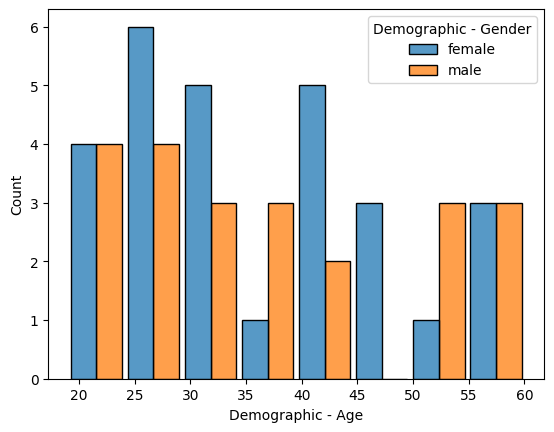

In [80]:
# Get the max and min age
print(demographics["Demographic - Age"].max(), demographics["Demographic - Age"].min())

# convert the age to a numeric value
demographics["Demographic - Age"] = pd.to_numeric(
    demographics["Demographic - Age"], errors="coerce"
)

# graph an histogram of the ages
sns.histplot(
    data=demographics,
    x="Demographic - Age",
    binwidth=5,
    hue="Demographic - Gender",
    multiple="dodge",
    shrink=0.9,
)

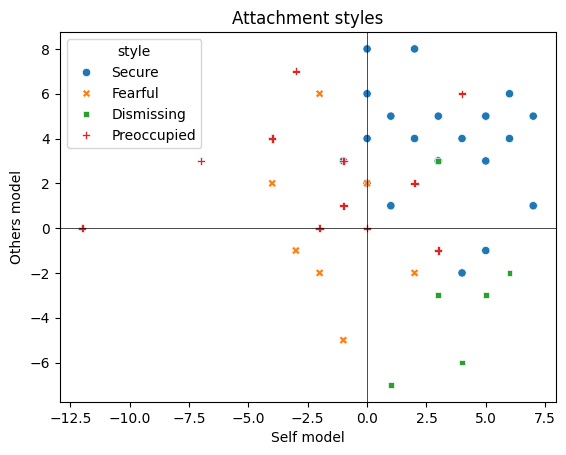

In [81]:
# graph the attachment styles from RQ Model of self (anxiety) and others (avoidance)

rq_dataframe = df.from_dict([answer.get("RQ score") for answer in full_answers])

graph = sns.scatterplot(
    data=rq_dataframe, x="anxiety", y="avoidance", hue="style", style="style"
)
graph.set_title("Attachment styles")
graph.set_xlabel("Self model")
graph.set_ylabel("Others model")
graph.axhline(0, color="black", linewidth=0.5)
graph.axvline(0, color="black", linewidth=0.5)
plt.show()

In [82]:
# Categorize the persons by styles from the anxiety and avoidance cuadrants of the RQ model
# Secure if coordinates are bigger than 0, 0, insecure otherwise. For the ambiguous cases check the style

for answer in full_answers:
    if (
        answer.get("RQ score").get("anxiety") > 0
        and answer.get("RQ score").get("avoidance") > 0
    ):
        answer["RQ2_style"] = "secure"
    elif (
        answer.get("RQ score").get("anxiety") < 0
        or answer.get("RQ score").get("avoidance") < 0
    ):
        answer["RQ2_style"] = "insecure"
    else:
        print(f"answer with anxiety {answer.get('RQ score').get('anxiety')} and avoidance {answer.get('RQ score').get('avoidance')} is ambiguous")
        if answer.get("RQ score").get("anxiety") == 0 and answer.get("RQ score").get("avoidance") > 0:
            answer["RQ2_style"] = "secure"
        elif answer.get("RQ score").get("anxiety") > 0 and answer.get("RQ score").get("avoidance") == 0:
            answer["RQ2_style"] = "secure"
        elif answer.get("RQ score").get("style").lower() == "secure":
            answer["RQ2_style"] = "secure"
        else:
            answer["RQ2_style"] = "insecure"
        print(answer.get("RQ2_style"))

# get a dataframe with the attachment styles from RQ2
rq2_dataframe = df.from_dict([answer.get("RQ2_style") for answer in full_answers])
rq2_dataframe.describe()

answer with anxiety 0 and avoidance 2 is ambiguous
secure
answer with anxiety 0 and avoidance 0 is ambiguous
insecure
answer with anxiety 0 and avoidance 6 is ambiguous
secure
answer with anxiety 0 and avoidance 4 is ambiguous
secure
answer with anxiety 0 and avoidance 8 is ambiguous
secure
answer with anxiety 0 and avoidance 2 is ambiguous
secure


,0
count,50
unique,2
top,secure
freq,26


#### Get the ROC curve
The analysis includes some segmentations of the population:
- Per gender
- Secure and Insecure styles
- Considering only the self reported answered from RQ (Also RQ1 in other places)

ROC Curve - full sample RQ 2
50
llm                26
llm_image_1        28
llm_image_2        26
llm_image_3        26
llm_image_4        26
llm_image_5        25
llm_image_6        22
llm_image_7        26
llm_image_8        28
llm_description    26
llm_past           26
llm_present        26
llm_future         26
dtype: int64
True Positive rate: 
 llm                0.52
llm_image_1        0.56
llm_image_2        0.52
llm_image_3        0.52
llm_image_4        0.52
llm_image_5        0.50
llm_image_6        0.44
llm_image_7        0.52
llm_image_8        0.56
llm_description    0.52
llm_past           0.52
llm_present        0.52
llm_future         0.52
dtype: float64
False Positive rate: 
 llm                0.48
llm_image_1        0.44
llm_image_2        0.48
llm_image_3        0.48
llm_image_4        0.48
llm_image_5        0.50
llm_image_6        0.56
llm_image_7        0.48
llm_image_8        0.44
llm_description    0.48
llm_past           0.48
llm_present        0.48
llm_futur

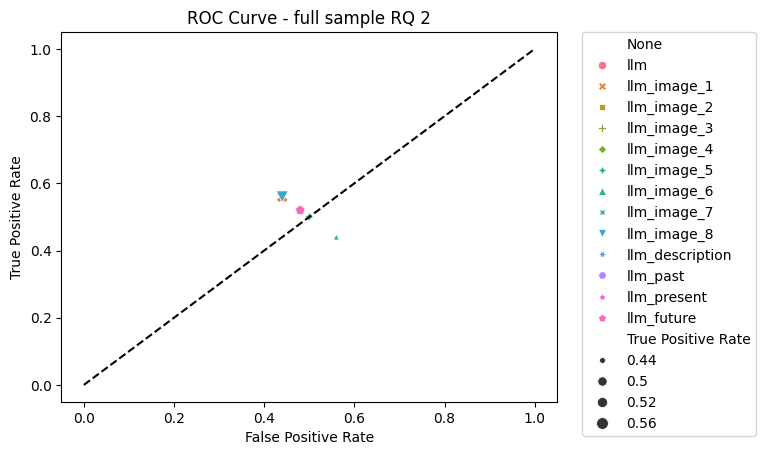

ROC Curve - secure sample RQ 2
26
llm                16
llm_image_1        23
llm_image_2        19
llm_image_3        17
llm_image_4        20
llm_image_5        17
llm_image_6        10
llm_image_7        11
llm_image_8        22
llm_description    21
llm_past           14
llm_present        12
llm_future         21
dtype: int64
True Positive rate: 
 llm                0.62
llm_image_1        0.88
llm_image_2        0.73
llm_image_3        0.65
llm_image_4        0.77
llm_image_5        0.65
llm_image_6        0.38
llm_image_7        0.42
llm_image_8        0.85
llm_description    0.81
llm_past           0.54
llm_present        0.46
llm_future         0.81
dtype: float64
False Positive rate: 
 llm                0.38
llm_image_1        0.12
llm_image_2        0.27
llm_image_3        0.35
llm_image_4        0.23
llm_image_5        0.35
llm_image_6        0.62
llm_image_7        0.58
llm_image_8        0.15
llm_description    0.19
llm_past           0.46
llm_present        0.54
llm_fut

/tmp/ipykernel_2399/236026339.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[column] = df_data.apply(
/tmp/ipykernel_2399/236026339.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.drop(columns=["RQ"], inplace=True)


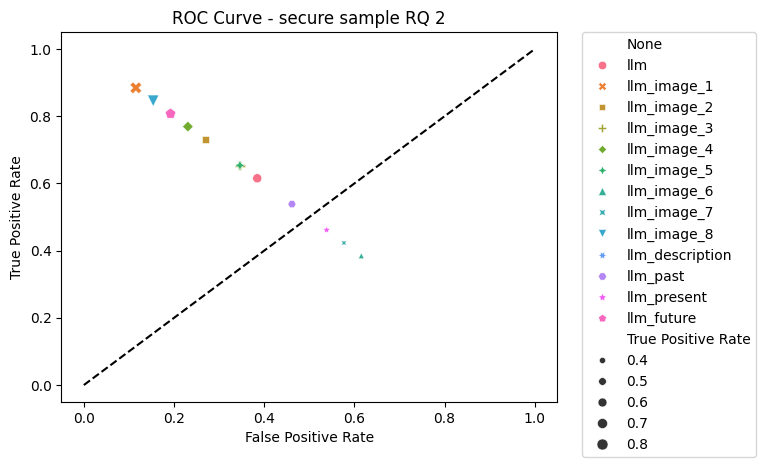

ROC Curve - insecure sample RQ 2
24
llm                10
llm_image_1         5
llm_image_2         7
llm_image_3         9
llm_image_4         6
llm_image_5         8
llm_image_6        12
llm_image_7        15
llm_image_8         6
llm_description     5
llm_past           12
llm_present        14
llm_future          5
dtype: int64
True Positive rate: 
 llm                0.42
llm_image_1        0.21
llm_image_2        0.29
llm_image_3        0.38
llm_image_4        0.25
llm_image_5        0.33
llm_image_6        0.50
llm_image_7        0.62
llm_image_8        0.25
llm_description    0.21
llm_past           0.50
llm_present        0.58
llm_future         0.21
dtype: float64
False Positive rate: 
 llm                0.58
llm_image_1        0.79
llm_image_2        0.71
llm_image_3        0.62
llm_image_4        0.75
llm_image_5        0.67
llm_image_6        0.50
llm_image_7        0.38
llm_image_8        0.75
llm_description    0.79
llm_past           0.50
llm_present        0.42
llm_f

/tmp/ipykernel_2399/236026339.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[column] = df_data.apply(
/tmp/ipykernel_2399/236026339.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.drop(columns=["RQ"], inplace=True)


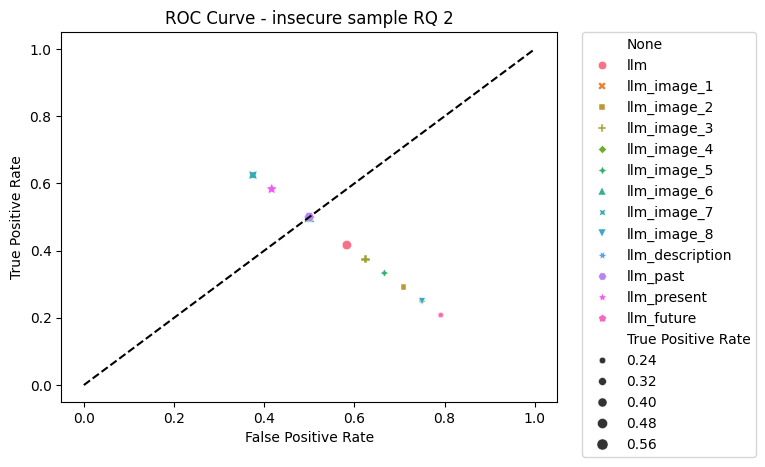

ROC Curve - female sample RQ 2
28
llm                14
llm_image_1        16
llm_image_2        15
llm_image_3        15
llm_image_4        13
llm_image_5        13
llm_image_6        11
llm_image_7        14
llm_image_8        16
llm_description    14
llm_past           15
llm_present        15
llm_future         14
dtype: int64
True Positive rate: 
 llm                0.50
llm_image_1        0.57
llm_image_2        0.54
llm_image_3        0.54
llm_image_4        0.46
llm_image_5        0.46
llm_image_6        0.39
llm_image_7        0.50
llm_image_8        0.57
llm_description    0.50
llm_past           0.54
llm_present        0.54
llm_future         0.50
dtype: float64
False Positive rate: 
 llm                0.50
llm_image_1        0.43
llm_image_2        0.46
llm_image_3        0.46
llm_image_4        0.54
llm_image_5        0.54
llm_image_6        0.61
llm_image_7        0.50
llm_image_8        0.43
llm_description    0.50
llm_past           0.46
llm_present        0.46
llm_fut

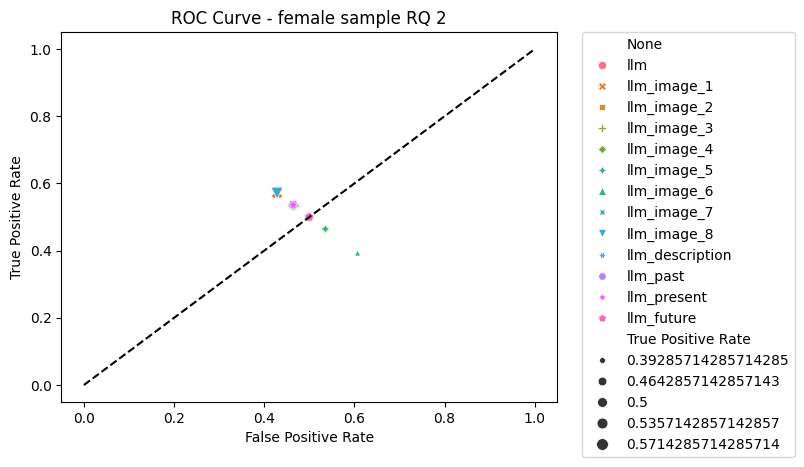

ROC Curve - male sample RQ 2
22
llm                12
llm_image_1        12
llm_image_2        11
llm_image_3        11
llm_image_4        13
llm_image_5        12
llm_image_6        11
llm_image_7        12
llm_image_8        12
llm_description    12
llm_past           11
llm_present        11
llm_future         12
dtype: int64
True Positive rate: 
 llm                0.55
llm_image_1        0.55
llm_image_2        0.50
llm_image_3        0.50
llm_image_4        0.59
llm_image_5        0.55
llm_image_6        0.50
llm_image_7        0.55
llm_image_8        0.55
llm_description    0.55
llm_past           0.50
llm_present        0.50
llm_future         0.55
dtype: float64
False Positive rate: 
 llm                0.45
llm_image_1        0.45
llm_image_2        0.50
llm_image_3        0.50
llm_image_4        0.41
llm_image_5        0.45
llm_image_6        0.50
llm_image_7        0.45
llm_image_8        0.45
llm_description    0.45
llm_past           0.50
llm_present        0.50
llm_futur

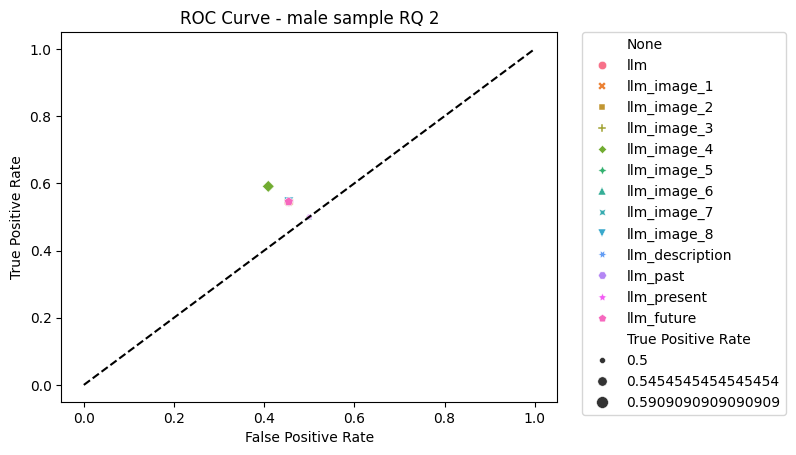

ROC Curve - full sample RQ 1
50
llm                29
llm_image_1        29
llm_image_2        29
llm_image_3        25
llm_image_4        29
llm_image_5        30
llm_image_6        25
llm_image_7        29
llm_image_8        27
llm_description    29
llm_past           31
llm_present        29
llm_future         27
dtype: int64
True Positive rate: 
 llm                0.58
llm_image_1        0.58
llm_image_2        0.58
llm_image_3        0.50
llm_image_4        0.58
llm_image_5        0.60
llm_image_6        0.50
llm_image_7        0.58
llm_image_8        0.54
llm_description    0.58
llm_past           0.62
llm_present        0.58
llm_future         0.54
dtype: float64
False Positive rate: 
 llm                0.42
llm_image_1        0.42
llm_image_2        0.42
llm_image_3        0.50
llm_image_4        0.42
llm_image_5        0.40
llm_image_6        0.50
llm_image_7        0.42
llm_image_8        0.46
llm_description    0.42
llm_past           0.38
llm_present        0.42
llm_futur

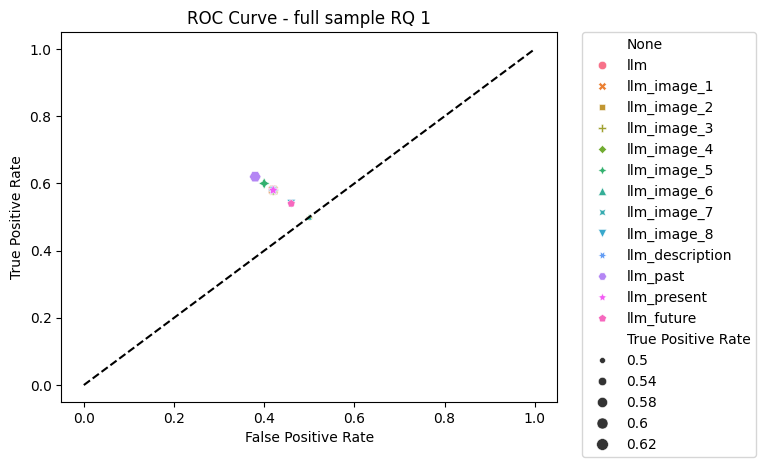

ROC Curve - secure sample RQ 1
25
llm                17
llm_image_1        23
llm_image_2        20
llm_image_3        16
llm_image_4        21
llm_image_5        19
llm_image_6        11
llm_image_7        12
llm_image_8        21
llm_description    22
llm_past           16
llm_present        13
llm_future         21
dtype: int64
True Positive rate: 
 llm                0.68
llm_image_1        0.92
llm_image_2        0.80
llm_image_3        0.64
llm_image_4        0.84
llm_image_5        0.76
llm_image_6        0.44
llm_image_7        0.48
llm_image_8        0.84
llm_description    0.88
llm_past           0.64
llm_present        0.52
llm_future         0.84
dtype: float64
False Positive rate: 
 llm                0.32
llm_image_1        0.08
llm_image_2        0.20
llm_image_3        0.36
llm_image_4        0.16
llm_image_5        0.24
llm_image_6        0.56
llm_image_7        0.52
llm_image_8        0.16
llm_description    0.12
llm_past           0.36
llm_present        0.48
llm_fut

/tmp/ipykernel_2399/236026339.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[column] = df_data.apply(
/tmp/ipykernel_2399/236026339.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.drop(columns=["RQ"], inplace=True)


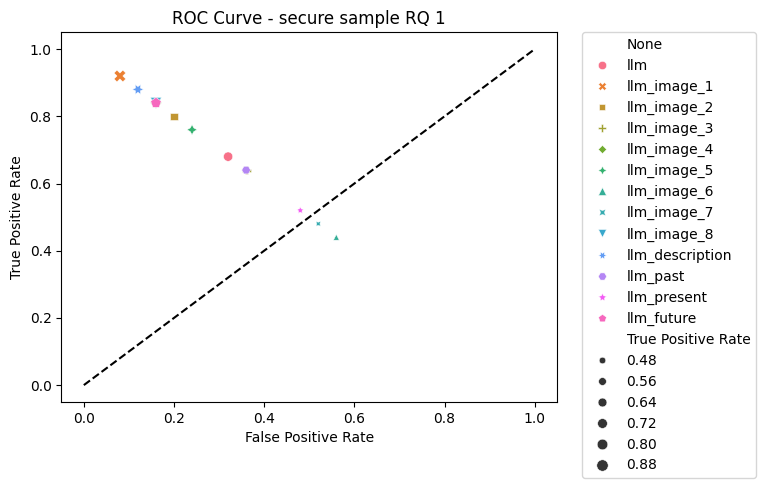

ROC Curve - insecure sample RQ 1
25
llm                12
llm_image_1         6
llm_image_2         9
llm_image_3         9
llm_image_4         8
llm_image_5        11
llm_image_6        14
llm_image_7        17
llm_image_8         6
llm_description     7
llm_past           15
llm_present        16
llm_future          6
dtype: int64
True Positive rate: 
 llm                0.48
llm_image_1        0.24
llm_image_2        0.36
llm_image_3        0.36
llm_image_4        0.32
llm_image_5        0.44
llm_image_6        0.56
llm_image_7        0.68
llm_image_8        0.24
llm_description    0.28
llm_past           0.60
llm_present        0.64
llm_future         0.24
dtype: float64
False Positive rate: 
 llm                0.52
llm_image_1        0.76
llm_image_2        0.64
llm_image_3        0.64
llm_image_4        0.68
llm_image_5        0.56
llm_image_6        0.44
llm_image_7        0.32
llm_image_8        0.76
llm_description    0.72
llm_past           0.40
llm_present        0.36
llm_f

/tmp/ipykernel_2399/236026339.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[column] = df_data.apply(
/tmp/ipykernel_2399/236026339.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.drop(columns=["RQ"], inplace=True)


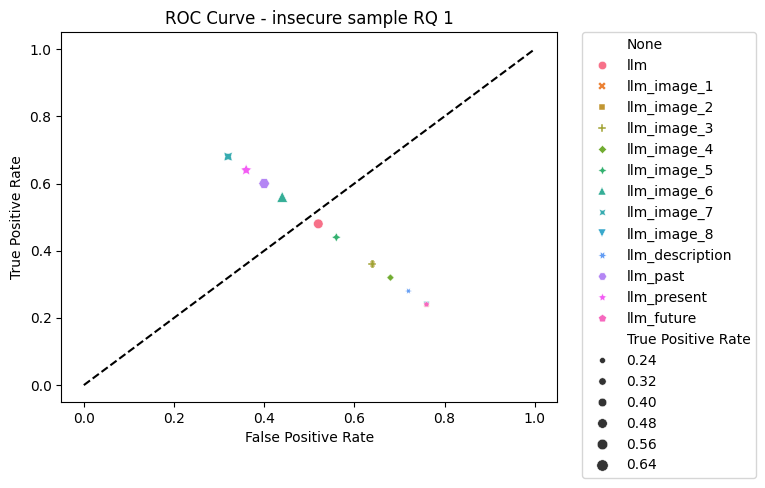

ROC Curve - female sample RQ 1
28
llm                16
llm_image_1        14
llm_image_2        15
llm_image_3        13
llm_image_4        13
llm_image_5        15
llm_image_6        13
llm_image_7        16
llm_image_8        14
llm_description    14
llm_past           17
llm_present        17
llm_future         14
dtype: int64
True Positive rate: 
 llm                0.57
llm_image_1        0.50
llm_image_2        0.54
llm_image_3        0.46
llm_image_4        0.46
llm_image_5        0.54
llm_image_6        0.46
llm_image_7        0.57
llm_image_8        0.50
llm_description    0.50
llm_past           0.61
llm_present        0.61
llm_future         0.50
dtype: float64
False Positive rate: 
 llm                0.43
llm_image_1        0.50
llm_image_2        0.46
llm_image_3        0.54
llm_image_4        0.54
llm_image_5        0.46
llm_image_6        0.54
llm_image_7        0.43
llm_image_8        0.50
llm_description    0.50
llm_past           0.39
llm_present        0.39
llm_fut

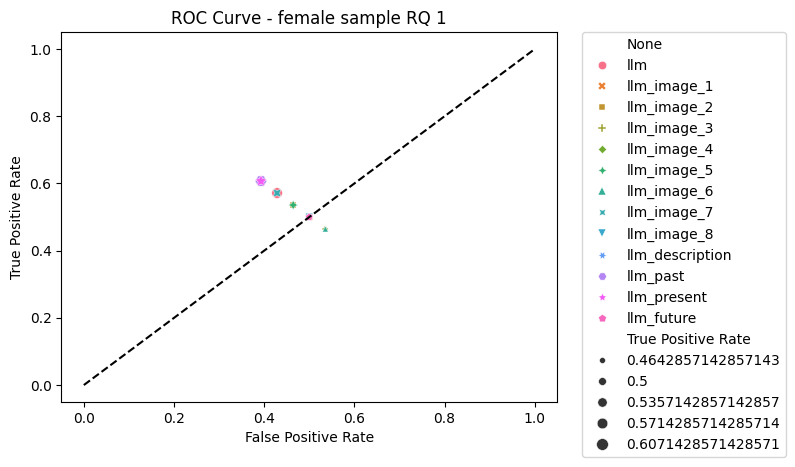

ROC Curve - male sample RQ 1
22
llm                13
llm_image_1        15
llm_image_2        14
llm_image_3        12
llm_image_4        16
llm_image_5        15
llm_image_6        12
llm_image_7        13
llm_image_8        13
llm_description    15
llm_past           14
llm_present        12
llm_future         13
dtype: int64
True Positive rate: 
 llm                0.59
llm_image_1        0.68
llm_image_2        0.64
llm_image_3        0.55
llm_image_4        0.73
llm_image_5        0.68
llm_image_6        0.55
llm_image_7        0.59
llm_image_8        0.59
llm_description    0.68
llm_past           0.64
llm_present        0.55
llm_future         0.59
dtype: float64
False Positive rate: 
 llm                0.41
llm_image_1        0.32
llm_image_2        0.36
llm_image_3        0.45
llm_image_4        0.27
llm_image_5        0.32
llm_image_6        0.45
llm_image_7        0.41
llm_image_8        0.41
llm_description    0.32
llm_past           0.36
llm_present        0.45
llm_futur

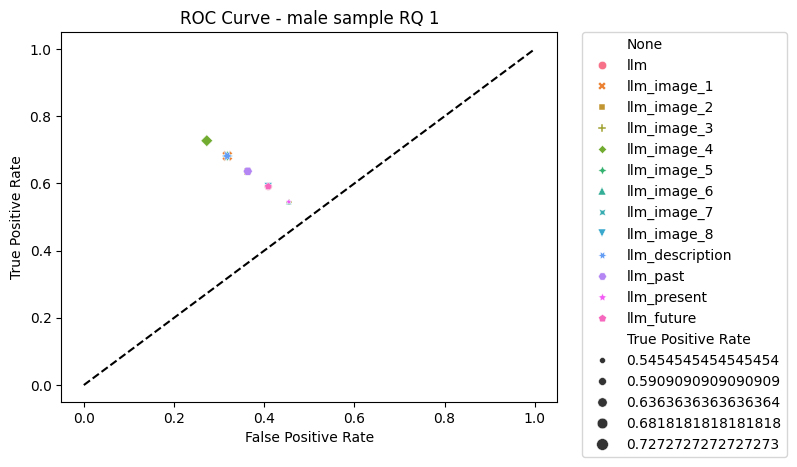

In [88]:
df_style_female_rq2 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ2_style"),
        }
        for answer in  full_answers if answer.get("Demographic - Gender") == "female"
    ]
)

def_style_male_rq2 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ2_style"),
        }
        for answer in  full_answers if answer.get("Demographic - Gender") == "male"
    ]
)


df_style_rq_2 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ2_style"),
        }
        for answer in full_answers
    ]
)

df_style_rq_1 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ_result_style"),
        }
        for answer in full_answers
    ]
)

df_style_female_rq1 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ_result_style"),
        }
        for answer in  full_answers if answer.get("Demographic - Gender") == "female"
    ]
)

def_style_male_rq1 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ_result_style"),
        }
        for answer in  full_answers if answer.get("Demographic - Gender") == "male"
    ]
)


df_style_rq_2_secure = df_style_rq_2[df_style_rq_2["RQ"] == "secure"]
df_style_rq_2_insecure = df_style_rq_2[df_style_rq_2["RQ"] == "insecure"]

df_style_rq_1_secure = df_style_rq_1[df_style_rq_1["RQ"] == "Secure"]
df_style_rq_1_insecure = df_style_rq_1[df_style_rq_1["RQ"] != "Secure"]

df_styling_dict = [
    {"data": df_style_rq_2, "title": "ROC Curve - full sample RQ 2"},
    {"data": df_style_rq_2_secure, "title": "ROC Curve - secure sample RQ 2"},
    {"data": df_style_rq_2_insecure, "title": "ROC Curve - insecure sample RQ 2"},
    {"data": df_style_female_rq2, "title": "ROC Curve - female sample RQ 2"},
    {"data": def_style_male_rq2, "title": "ROC Curve - male sample RQ 2"},
    {"data": df_style_rq_1, "title": "ROC Curve - full sample RQ 1"},
    {"data": df_style_rq_1_secure, "title": "ROC Curve - secure sample RQ 1"},
    {"data": df_style_rq_1_insecure, "title": "ROC Curve - insecure sample RQ 1"},
    {"data": df_style_female_rq1, "title": "ROC Curve - female sample RQ 1"},
    {"data": def_style_male_rq1, "title": "ROC Curve - male sample RQ 1"},
]

def custom_is_equal(llm: str, rq: str) -> bool:
    rq_lower = rq.lower()
    llm_lower = llm.lower()
    if rq_lower != "secure":
        rq_lower = "insecure"
    if llm_lower != "secure":
        llm_lower = "insecure"
    return llm == rq_lower


# Compare each column with the RQ style and set the value to 1 if they match and 0 if they don't
for roc_style_data in df_styling_dict:
    # print the length of the dataframe
    df_data = roc_style_data.get("data")
    print(roc_style_data.get("title"))
    print(len(df_data))
    for column in df_data.columns:
        if column == "RQ":
            continue
        df_data[column] = df_data.apply(
            lambda x: 1 if custom_is_equal(x.get(column), x.get("RQ")) else 0, axis=1
        )

    df_data.drop(columns=["RQ"], inplace=True)

    # get the percentage of matches per column
    matches = df_data.sum()
    print(matches)
    # Calculate the False Positive Rate and True Positive Rate

    int_matches = matches.astype(int)
    true_positive_rate = int_matches / len(df_data)
    false_positive_rate = 1 - true_positive_rate
    # print the rates rounded to two decimals
    print("True Positive rate: \n", round(true_positive_rate, 2))
    print("False Positive rate: \n", round(false_positive_rate, 2))

    # Calculate the ROC curve
    roc_curve = pd.DataFrame(
        {
            "False Positive Rate": false_positive_rate,
            "True Positive Rate": true_positive_rate,
        }
    )

    graph = sns.scatterplot(
        data=roc_curve,
        x="False Positive Rate",
        y="True Positive Rate",
        hue=roc_curve.index,
        style=roc_curve.index,
        size="True Positive Rate",
    )

    # Add the diagonal line
    graph.plot([0, 1], [0, 1], color="black", linestyle="--")
    graph.set_title(roc_style_data.get("title"))
    # put the legend outside the graph
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    #show the high definition graph
    plt.show()

#### HADS comparison with the secondary data points for anxiety and depression from the LLM

In [ ]:
# get HADS scores and llm depression and anxiety averages
df["llm_depression_average"] = df["llm_depression_average"].apply(
    lambda x: int(x) if x is not None else None
)
df["llm_anxiety_average"] = df["llm_anxiety_average"].apply(
    lambda x: int(x) if x is not None else None
)

# Standardize the HADS scores to 0-100.00 where 0 is the minimum and 21 is the maximum
# add a new column with the standard values
df.insert(
    len(df.columns),
    "HADS score - Anxiety 100",
    (
        df["HADS score - Anxiety"].apply(
            lambda x: round((x / 21) * 100, 2) if x is not None else None
        )
    ),
)

df.insert(
    len(df.columns),
    "HADS score - Depression 100",
    (
        df["HADS score - Depression"].apply(
            lambda x: round((x / 21) * 100, 2) if x is not None else None
        )
    ),
)

df.insert(
    len(df.columns),
    "depression_distance",
    (df["HADS score - Depression 100"] - df["llm_depression_average"]),
)
df.insert(
    len(df.columns),
    "anxiety_distance",
    (df["HADS score - Anxiety 100"] - df["llm_anxiety_average"]),
)

# print the columns with the HADS score and the llm depression and anxiety averages as a table
df[
    [
        "HADS score - Anxiety 100",
        "llm_anxiety_average",
        "HADS score - Depression 100",
        "llm_depression_average",
    ]
].describe()

,HADS score - Anxiety 100,llm_anxiety_average,HADS score - Depression 100,llm_depression_average
count,50.000000,50.000000,50.000000,50.000000
mean,34.761800,44.540000,34.190600,26.680000
std,18.709962,8.809109,11.887547,5.939972
min,0.000000,28.000000,9.520000,17.000000
25%,19.050000,38.000000,28.570000,22.000000
50%,33.330000,43.500000,33.330000,26.000000
75%,52.380000,50.750000,42.860000,30.750000
max,71.430000,67.000000,61.900000,39.000000


In [ ]:
# Graph the average distance from the HADS scores to the ones selected by the LLM
df[["depression_distance", "anxiety_distance"]].describe()

,depression_distance,anxiety_distance
count,50.00000,50.000000
mean,7.51060,-9.778200
std,12.91158,19.183693
min,-21.71000,-47.950000
25%,0.94000,-21.890000
50%,6.81000,-8.310000
75%,16.18000,2.680000
max,37.90000,25.900000


In [ ]:
# generate distances for each image and the description, past, present and future
for img_num in range(1, 9):
    df.insert(
        len(df.columns),
        f"image_{img_num}_depression_distance",
        (df[f"image_{img_num}_llm_depression"] - df["HADS score - Depression 100"]),
    )
    df.insert(
        len(df.columns),
        f"image_{img_num}_anxiety_distance",
        (df[f"image_{img_num}_llm_anxiety"] - df["HADS score - Anxiety 100"]),
    )

df.insert(
    len(df.columns),
    "description_depression_distance",
    (df["description_llm_depression"] - df["HADS score - Depression 100"]),
)
df.insert(
    len(df.columns),
    "description_anxiety_distance",
    (df["description_llm_anxiety"] - df["HADS score - Anxiety 100"]),
)

df.insert(
    len(df.columns),
    "past_depression_distance",
    (df["past_llm_depression"] - df["HADS score - Depression 100"]),
)
df.insert(
    len(df.columns),
    "past_anxiety_distance",
    (df["past_llm_anxiety"] - df["HADS score - Anxiety 100"]),
)

df.insert(
    len(df.columns),
    "present_depression_distance",
    (df["present_llm_depression"] - df["HADS score - Depression 100"]),
)
df.insert(
    len(df.columns),
    "present_anxiety_distance",
    (df["present_llm_anxiety"] - df["HADS score - Anxiety 100"]),
)

df.insert(
    len(df.columns),
    "future_depression_distance",
    (df["future_llm_depression"] - df["HADS score - Depression 100"]),
)
df.insert(
    len(df.columns),
    "future_anxiety_distance",
    (df["future_llm_anxiety"] - df["HADS score - Anxiety 100"]),
)

In [ ]:
df[[col for col in df.columns if "distance" in col]].describe()

,depression_distance,anxiety_distance,image_1_depression_distance,image_1_anxiety_distance,image_2_depression_distance,image_2_anxiety_distance,image_3_depression_distance,image_3_anxiety_distance,image_4_depression_distance,image_4_anxiety_distance,...,image_8_depression_distance,image_8_anxiety_distance,description_depression_distance,description_anxiety_distance,past_depression_distance,past_anxiety_distance,present_depression_distance,present_anxiety_distance,future_depression_distance,future_anxiety_distance
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.00000,50.000000,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,7.51060,-9.778200,-15.465600,-4.111800,-14.540600,-1.311800,-12.490600,2.588200,-11.165600,5.338200,...,-12.665600,3.738200,-8.57810,7.513200,-5.81560,13.46320,-2.365600,15.788200,-11.153100,4.138200
std,12.91158,19.183693,14.504366,21.838748,14.465391,21.673466,15.765049,21.950929,17.190507,22.340679,...,15.367288,21.614055,12.79927,20.519261,13.27309,19.68194,15.483795,19.998174,13.987314,21.091564
min,-21.71000,-47.950000,-56.900000,-51.430000,-58.150000,-41.900000,-53.150000,-41.900000,-45.650000,-41.900000,...,-45.890000,-31.900000,-36.27500,-31.900000,-39.40000,-22.62000,-30.025000,-19.400000,-44.400000,-31.900000
25%,0.94000,-21.890000,-24.290000,-17.800000,-22.202500,-12.320000,-21.595000,-9.312500,-21.610000,-12.142500,...,-21.610000,-11.427500,-16.67375,-8.092500,-10.97000,-0.95000,-13.040000,1.682500,-19.193750,-9.580000
50%,6.81000,-8.310000,-17.115000,-3.930000,-15.835000,-3.215000,-15.090000,3.570000,-11.695000,5.835000,...,-12.230000,1.785000,-6.84500,8.035000,-6.60500,12.32000,-2.945000,14.645000,-9.970000,3.035000
75%,16.18000,2.680000,-4.880000,10.240000,-4.302500,11.610000,-3.052500,20.592500,-2.425000,20.712500,...,-3.822500,15.890000,-0.22875,21.550000,-0.03625,25.89000,7.067500,28.930000,-4.015000,16.490000
max,37.90000,25.900000,14.170000,50.950000,16.190000,60.950000,22.680000,55.950000,29.230000,55.950000,...,16.960000,60.480000,21.73000,42.740000,26.33500,55.48000,37.585000,57.980000,23.690000,60.950000


Text(0.5, 0, 'Difference')

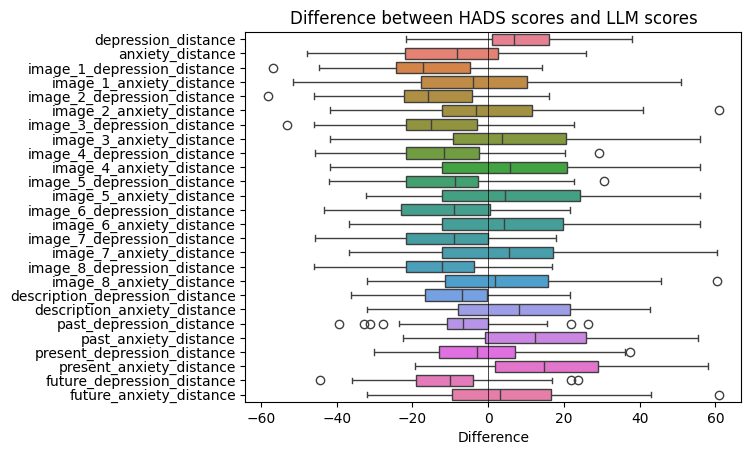

In [ ]:
# graph the distances
graph = sns.boxplot(
    data=df[[col for col in df.columns if "distance" in col]],
    orient="h",
    gap=0.01,
)
graph.set_title("Difference between HADS scores and LLM scores")
graph.axvline(0, color="black", linewidth=0.5)
graph.set_xlabel("Difference")

/tmp/ipykernel_2399/2404488468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["HADS score - Anxiety 100"] = df["HADS score - Anxiety 100"]
/tmp/ipykernel_2399/2404488468.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["HADS score - Depression 100"] = df["HADS score - Depression 100"]


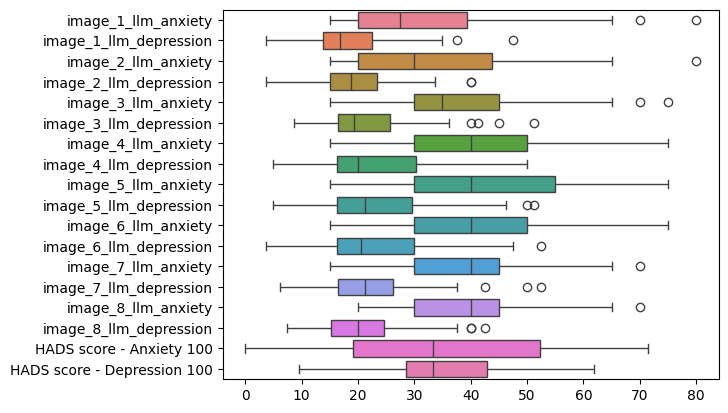

In [ ]:
image_df = df[[col for col in df.columns if "image" in col and "llm" in col]]

# Add the HADS scores to the dataframe
image_df["HADS score - Anxiety 100"] = df["HADS score - Anxiety 100"]
image_df["HADS score - Depression 100"] = df["HADS score - Depression 100"]

# graph the distances for each image
graph = sns.boxplot(
    data=image_df,
    orient="h",
    gap=0.01,
)

34.7618


/tmp/ipykernel_2399/1797811677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anxiety_df["HADS score - Anxiety 100"] = df["HADS score - Anxiety 100"]


Text(0.5, 0, 'scores')

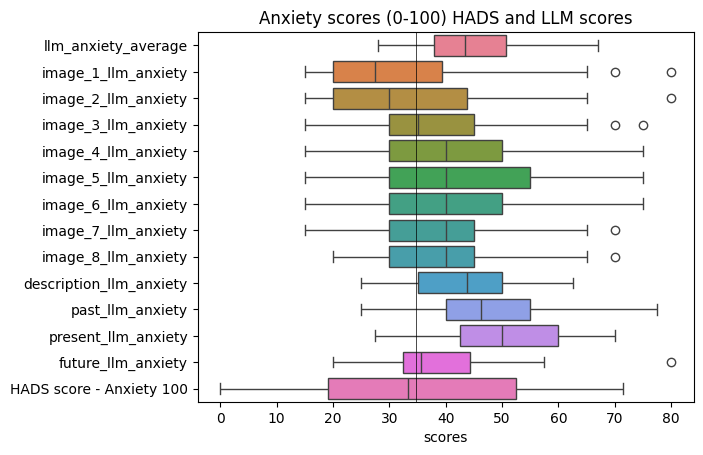

In [ ]:
# Do the boxplot only for anxiety
anxiety_df = df[[col for col in df.columns if "anxiety" in col and "llm" in col and col != "llm_anxiety"]]
anxiety_df["HADS score - Anxiety 100"] = df["HADS score - Anxiety 100"]
# Get the mean for HADS anxiety
mean_anxiety = anxiety_df["HADS score - Anxiety 100"].mean()
print(mean_anxiety)

# graph the distances for each image
graph = sns.boxplot(
    data=anxiety_df,
    orient="h",
    gap=0.01,
)
graph.axvline(mean_anxiety, color="black", linewidth=0.5)
graph.set_title("Anxiety scores (0-100) HADS and LLM scores")
graph.set_xlabel("scores")



/tmp/ipykernel_2399/3117761812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depression_df["HADS score - Depression 100"] = df["HADS score - Depression 100"]


34.190599999999996


Text(0.5, 0, 'scores')

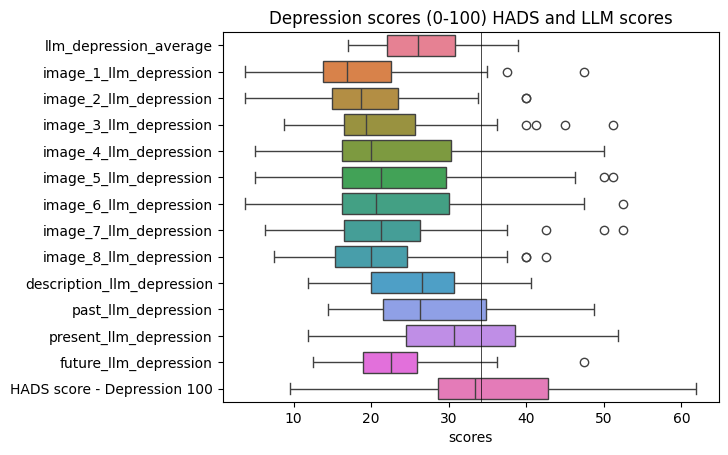

In [ ]:
# Do the boxplot only for depression
depression_df = df[[col for col in df.columns if "depression" in col and "llm" in col and col != "llm_depression"]]
depression_df["HADS score - Depression 100"] = df["HADS score - Depression 100"]
# Get the mean for HADS depression
mean_depression = depression_df["HADS score - Depression 100"].mean()
print(mean_depression)

# graph the distances for each image
graph = sns.boxplot(
    data=depression_df,
    orient="h",
    gap=0.01,
)
graph.axvline(mean_depression, color="black", linewidth=0.5)
graph.set_title("Depression scores (0-100) HADS and LLM scores")
graph.set_xlabel("scores")

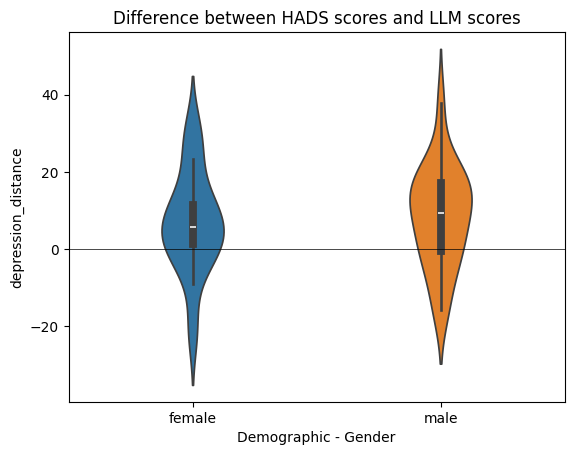

In [ ]:
graph = sns.violinplot(
    data=df,
    hue="Demographic - Gender",
    y="depression_distance",
    x="Demographic - Gender",
    width=0.5,
    gap=0.5,
    inner="box"
)
graph.set_title("Difference between HADS scores and LLM scores")
graph.axhline(0, color="black", linewidth=0.5)

In [ ]:
graph = sns.violinplot(
    data=df,
    x="RQ_result_style",
    y="depression_distance",
    hue="Demographic - Gender",
    density_norm="count",
)
graph.axhline(0, color="black")
graph.set_title("Depression distance by attachment style")

ValueError: Could not interpret value `RQ_result_style` for `x`. An entry with this name does not appear in `data`.

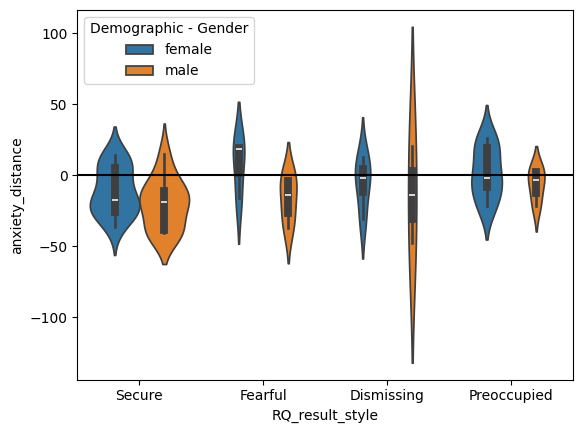

In [ ]:
graph = sns.violinplot(
    data=df,
    x="RQ_result_style",
    y="anxiety_distance",
    hue="Demographic - Gender",
    density_norm="count",
)
graph.axhline(0, color="black")

In order to run a statistical test, we need to test normality for the results generated by the llm and the HADS survey

In [ ]:
# test for normality for llm_depression_average and llm_anxiety_average, images and description, past, present and future
from scipy.stats import normaltest

col_to_test = [
    "llm_depression_average",
    "llm_anxiety_average",
    "HADS score - Depression 100",
    "HADS score - Anxiety 100",
]

for img_num in range(1, 9):
    col_to_test.append(f"image_{img_num}_llm_depression")
    col_to_test.append(f"image_{img_num}_llm_anxiety")

for time in ["description", "past", "present", "future"]:
    col_to_test.append(f"{time}_llm_depression")
    col_to_test.append(f"{time}_llm_anxiety")

normal_cols = []
non_normal_cols = []

for col in col_to_test:
    stat, p_value = normaltest(df[col])
    if p_value < 0.05:
        print(f"Column {col} is not normally distributed ({stat}, {p_value})")
        non_normal_cols.append(col)
    else:
        print(f"Column {col} is normally distributed ({stat}, {p_value})")
        normal_cols.append(col)

print(normal_cols)
print(non_normal_cols)

Column llm_depression_average is normally distributed (4.136668345165256, 0.12639616061871697)
Column llm_anxiety_average is normally distributed (2.1415197131945223, 0.3427479791322331)
Column HADS score - Depression 100 is normally distributed (1.0914506378261286, 0.5794213656147001)
Column HADS score - Anxiety 100 is not normally distributed (6.0520211749550015, 0.048508774131286146)
Column image_1_llm_depression is not normally distributed (12.9384482901839, 0.001550428173715203)
Column image_1_llm_anxiety is not normally distributed (17.76393999190457, 0.00013887032194279125)
Column image_2_llm_depression is normally distributed (3.278867097944787, 0.19408995361193424)
Column image_2_llm_anxiety is not normally distributed (7.067869807104815, 0.029189830423047163)
Column image_3_llm_depression is not normally distributed (14.972460105483723, 0.0005607529898272104)
Column image_3_llm_anxiety is not normally distributed (6.6115744823567555, 0.036670332074775235)
Column image_4_llm_d

Only the anxiety results from HADS are normal, therefore we will need to use a non-parametric test to check if the values are statistically different

In [ ]:
from scipy.stats import wilcoxon, ttest_ind

# Do one way anova for the normal columns and HADS depression
depression_stats = []
for col in normal_cols:
    if "depression" in col and col != "HADS score - Depression 100":
        stat, p_value = ttest_ind(
            df[col].dropna(), df["HADS score - Depression 100"].dropna()
        )
        is_significant = "significant" if p_value < 0.05 else "not significant"
        mean, std = df[col].mean(), df[col].std()
        depression_stats.append([f"{col}", mean, std, stat, p_value, is_significant])

# Use non-parametric Wilcoxon test for the non-normal columns
for col in non_normal_cols:
    if "depression" in col and col != "HADS score - Depression 100":
        stat, p_value = wilcoxon(
            df[col].dropna(), df["HADS score - Depression 100"].dropna()
        )
        is_significant = "significant" if p_value < 0.05 else "not significant"
        mean, std = df[col].mean(), df[col].std()
        depression_stats.append([f"{col}", mean, std, stat, p_value, is_significant])

depression_stats_df = pd.DataFrame(
    depression_stats,
    columns=["Data name", "Mean", "SD", "Statistic", "P-value", "Result"],
)
depression_stats_df.sort_values(by="Data name", inplace=True)
depression_stats_df

,Data name,Mean,SD,Statistic,P-value,Result
5,description_llm_depression,25.6125,7.112088,-4.378684,2.991609e-05,significant
12,future_llm_depression,23.0375,6.544113,158.000000,6.783549e-07,significant
8,image_1_llm_depression,18.7250,8.543444,82.000000,1.756897e-09,significant
1,image_2_llm_depression,19.6500,8.101083,-7.147328,1.591231e-10,significant
9,image_3_llm_depression,21.7000,9.209024,171.000000,1.547186e-06,significant
10,image_4_llm_depression,23.0250,11.313849,239.000000,6.206319e-05,significant
2,image_5_llm_depression,23.9750,11.239195,-4.415489,2.596970e-05,significant
3,image_6_llm_depression,23.2750,10.826466,-4.800433,5.680497e-06,significant
11,image_7_llm_depression,22.8500,9.936148,207.000000,1.228890e-05,significant
4,image_8_llm_depression,21.5250,8.904575,-6.029799,2.904813e-08,significant


In [ ]:
# Anxiety is not normally distributed in HADS therefore we will use the Wilcoxon test only

anxiety_stats = []
for col in normal_cols:
    if "anxiety" in col and col != "HADS score - Anxiety 100":
        stat, p_value = wilcoxon(
            df[col].dropna(), df["HADS score - Anxiety 100"].dropna()
        )
        is_significant = "significant" if p_value < 0.05 else "not significant"
        mean, std = df[col].mean(), df[col].std()
        anxiety_stats.append([f"{col}", mean, std, stat, p_value, is_significant])

for col in non_normal_cols:
    if "anxiety" in col and col != "HADS score - Anxiety 100":
        stat, p_value = wilcoxon(
            df[col].dropna(), df["HADS score - Anxiety 100"].dropna()
        )
        is_significant = "significant" if p_value < 0.05 else "not significant"
        mean, std = df[col].mean(), df[col].std()
        anxiety_stats.append([f"{col}", mean, std, stat, p_value, is_significant])

anxiety_stats_df = pd.DataFrame(
    anxiety_stats, columns=["Data name", "Mean", "SD", "Statistic", "P-value", "Result"]
)
anxiety_stats_df.sort_values(by="Data name", inplace=True)
anxiety_stats_df

,Data name,Mean,SD,Statistic,P-value,Result
6,description_llm_anxiety,42.275,10.087911,404.5,0.024209,significant
12,future_llm_anxiety,38.900,10.701302,508.5,0.218662,not significant
9,image_1_llm_anxiety,30.650,14.921649,489.5,0.154303,not significant
10,image_2_llm_anxiety,33.450,15.376981,594.5,0.680645,not significant
11,image_3_llm_anxiety,37.350,14.253625,571.0,0.527279,not significant
1,image_4_llm_anxiety,40.100,16.019440,483.0,0.138073,not significant
2,image_5_llm_anxiety,41.600,16.176324,445.0,0.063466,not significant
3,image_6_llm_anxiety,39.700,14.512837,510.0,0.222315,not significant
4,image_7_llm_anxiety,39.100,14.345944,532.5,0.318325,not significant
5,image_8_llm_anxiety,38.500,12.586436,553.0,0.420723,not significant


This tells us that the data is statistically different, therefore the model is still not accurate for Style, Anxiety or Depression comparing against RQ and HADS.

Do a brief exploration around the Demographics of the excluded participants

In [ ]:
# Use the excluded answers to show how many were excluded by what reasons
reasons = {"excluded_by_diagnosis": 0, "excluded_by_psychiatric": 0, "excluded_by_substances": 0, "excluded_by_diag_psych": 0, "excluded_by_diag_substances": 0, "excluded_by_psych_substances": 0, "excluded_by_all": 0}
for answer in excluded_answers:
    if answer["Demographic - speech diagnosis"] == "yes" and answer["Demographic - psychiatric disorder"] == "yes" and answer["Demographic - Substances"] == "yes":
        reasons["excluded_by_all"] += 1
        continue

    if answer["Demographic - psychiatric disorder"] == "yes" and answer["Demographic - Substances"] == "yes":
        reasons["excluded_by_psych_substances"] += 1
        continue

    if answer["Demographic - speech diagnosis"] == "yes" and answer["Demographic - psychiatric disorder"] == "yes":
        reasons["excluded_by_diag_psych"] += 1
        continue

    if answer["Demographic - speech diagnosis"] == "yes" and answer["Demographic - Substances"] == "yes":
        reasons["excluded_by_diag_substances"] += 1
        continue

    if answer["Demographic - speech diagnosis"] == "yes":
        reasons["excluded_by_diagnosis"] += 1
        continue

    if answer["Demographic - psychiatric disorder"] == "yes":
        reasons["excluded_by_psychiatric"] += 1
        continue

    if answer["Demographic - Substances"] == "yes":
        reasons["excluded_by_substances"] += 1
        continue

print(reasons)


{'excluded_by_diagnosis': 3, 'excluded_by_psychiatric': 32, 'excluded_by_substances': 2, 'excluded_by_diag_psych': 1, 'excluded_by_diag_substances': 0, 'excluded_by_psych_substances': 18, 'excluded_by_all': 2}


In [ ]:
# check how many excluded come from prolific

excluded_from_prolific = len([answer for answer in excluded_answers if "PROLIFIC_PID" in answer.keys()])
print(excluded_from_prolific)

47
